### 1. Data Loading

In [1]:
# Data Loading
import pandas as pd
data = pd.read_csv('../data/jena_climate_2009_2016.csv')

# Date Time Ommit
data = data[data.columns[1:]]

# Numpy Array
import numpy as np
float_data = np.array(data)

In [2]:
data

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


### 2. Data Visualization

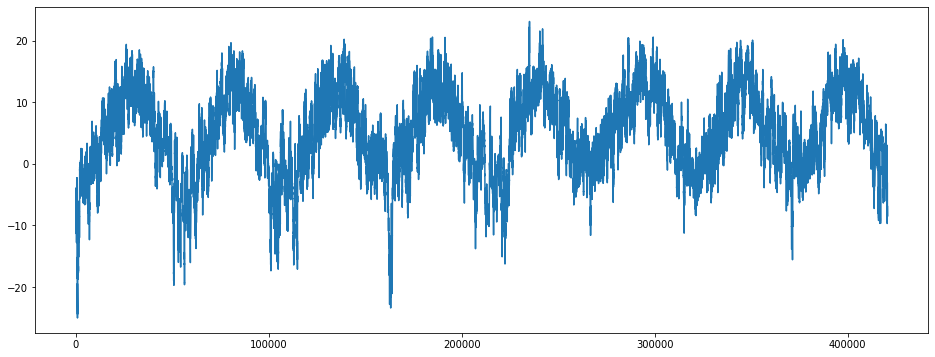

In [3]:
temp = float_data[:,3]
from matplotlib import pyplot as plt
plt.figure(figsize=(16,6))
plt.plot(range(len(temp)), temp)
plt.show()

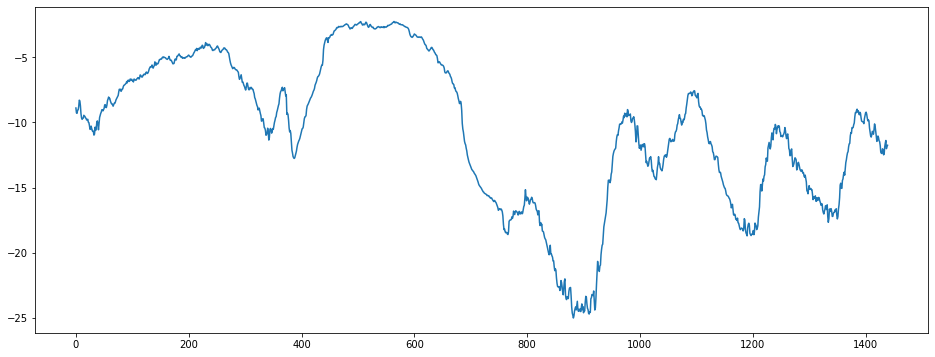

In [4]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,6))
plt.plot(range(1440), temp[:1440])
plt.show()

### 3. Data Normalization

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
mean

array([ 988.88635885,    9.07734895,  283.14631345,    4.44854725,
         75.35405895,   13.3829553 ,    9.29695535,    4.08591725,
          5.8752111 ,    9.40521005, 1217.51429655,    2.1510037 ,
          3.56950915,  176.21703355])

In [7]:
std

array([ 8.48043388,  8.85249908,  8.95324185,  7.16584991, 16.72731652,
        7.68914559,  4.19808168,  4.84034436,  2.66564926,  4.25206364,
       42.48884277,  1.53666449,  2.33067298, 86.61322998])

### 4. Generator
 - **data** : 정규화한 부동 소수 데이터로 이루어진 원본 배열
 - **lookback** : 입력으로 사용하기 위해 거슬러 올라갈 타임 스텝
 - **delay** : 타깃으로 사용할 미래의 타임스텝
 - **min_index와 max_index** : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스, 검증 데이터와 테스트 데이터를 분리하는데 사용.
 - **shuffle** : 샘플을 섞을지, 시간 순서대로 추출할지를 결정한다.
 - **batch_size** : 배치의 샘플 수
 - **step** : 데이터를 샘플링할 타임스텝 간격. 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정

In [8]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6) : 
    
    if max_index is None : 
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    
    while True : 
        if shuffle : 
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
            
        else : 
            if i + batch >= max_index : 
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros(len(rows), lookback // step, data.shape[-1])
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows) : 
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

In [14]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

# Train
train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

# Valid
val_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 200001,
                    max_index = 300000,
                    shuffle = True,
                    step = step,
                    batch_size = batch_size)

# Test
test_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     shuffle = True,
                     step = step,
                     batch_size = batch_size)


val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 5. 상식 수준의 기준점

In [15]:
def evalutate_navie_method() : 
    
    batch_maes = []
    
    for step in range(val_steps) : 
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    
    print(np.mean(batch_maes))
    
evalutate_navie_method()

TypeError: data type not understood

### 6. Model Build

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)






Epoch 1/20


TypeError: data type not understood

### 7. 결과 그래프

In [22]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.hisotru['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

### 8. GRU를 사용한 모델을 훈련하고 평가하기

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20


StopIteration: 

### 9. 드롭아웃 규제된 GRU 사용한 모델을 훈련하고 평가하기.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.2,
                     recurrent_dropout = 0.2,
                     input_shape = (None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epoch = 40,
                              validation_data = val_gen,
                              validation_data = val_steps)

### 10. 드롭아웃으로 규제하고, 스태킹한 GRU모델을 훈련하고 평가하기

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.1,
                     recurrent_dropout = 0.5,
                     return_sequences = True,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.GRU(64, 
                     activation = 'relu',
                     dropout = 0.1,
                     recurrent_dropout = 0.5))
model.add()